# Imports

In [1]:
import os, random, cv2, gc, torch, timm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import albumentations as A
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.metrics import cohen_kappa_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import seaborn as sns


/usr/local/lib/python3.12/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

# Hyperparameter and Environment Configuration

In [2]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DATA_DIR = "/kaggle/input/processed-dr-balanced" 
BATCH_SIZE = 16
ACCUM_STEPS = 4 
EPOCHS = 25      
LR = 1e-4       
WEIGHT_DECAY = 7e-5
MIN_LR = 1e-6
LABEL_SMOOTHING = 0.05
PATIENCE = 6     # The "Double Descent" safety net

# Data Preparation

In [3]:
# LOADING DATA 

all_paths = [] # Path to all images
all_labels = [] # labels sequential to images in all_paths

for label in ['0', '1', '2', '3', '4']:
    folder = os.path.join(DATA_DIR, label)
    if not os.path.exists(folder):
        continue
    imgs = [os.path.join(folder, f) for f in os.listdir(folder)]
    all_paths.extend(imgs)
    all_labels.extend([int(label)] * len(imgs))

# DATA SPLITTING
X_train,X_test, y_train,y_test = train_test_split(
    all_paths, all_labels, test_size=0.15, stratify=all_labels, random_state=42
)

In [4]:
# CREATING DATASET FOR PYTORCH 
class BalancedDataset(Dataset):
    def __init__(self, paths, labels, transform=None):
        self.paths, self.labels, self.transform = paths, labels, transform
        
    def __len__(self): return len(self.paths)
    
    def __getitem__(self, idx):
        # convert to RGB
        img = Image.open(self.paths[idx]).convert('RGB')
        
        if self.transform: 
            img = self.transform(img)
            
        return img, torch.tensor(self.labels[idx])
        
# Simplified transforms: No Resize or Gaussian needed
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Increased num_workers to 4 because CPU is no longer busy with math
train_loader = DataLoader(BalancedDataset(X_train, y_train, train_transform), 
                          batch_size=BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(BalancedDataset(X_test, y_test, val_transform), 
                        batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)

# Model & Training

In [5]:
model = timm.create_model('efficientnetv2_rw_s', pretrained=True, num_classes=5).to(DEVICE)
in_features = model.classifier.in_features
model.classifier = nn.Sequential(
    nn.Linear(in_features, 512),
    nn.BatchNorm1d(512),
    nn.SiLU(),
    nn.Dropout(0.3),
    nn.Linear(512, 5)
).to(DEVICE)

optimizer = optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
criterion = nn.CrossEntropyLoss(label_smoothing=LABEL_SMOOTHING)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS + 5, eta_min=MIN_LR )
scaler = torch.amp.GradScaler() 

best_kappa = -1.0
early_stop_counter = 0  # Initialize counter
history = [] 

for epoch in range(EPOCHS):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}") 
    
    optimizer.zero_grad()
    for i, (images, labels) in enumerate(pbar):
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        
        with torch.amp.autocast('cuda'):
            outputs = model(images)
            loss = criterion(outputs, labels) / ACCUM_STEPS
            
        scaler.scale(loss).backward()
        if (i + 1) % ACCUM_STEPS == 0:
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()
            
        running_loss += loss.item() * ACCUM_STEPS
        correct += (torch.argmax(outputs, 1) == labels).sum().item()
        total += labels.size(0)
        pbar.set_postfix({'loss': f"{running_loss/(i+1):.4f}", 'acc': f"{correct/total:.4f}"})

    # VALIDATION 
    model.eval()
    all_preds, all_labs = [], []
    with torch.no_grad():
        for images, labels in val_loader:
            with torch.amp.autocast('cuda'):
                outputs = model(images.to(DEVICE))
            all_preds.extend(outputs.argmax(1).detach().cpu().numpy())
            all_labs.extend(labels.cpu().numpy())

    val_kappa = cohen_kappa_score(all_labs, all_preds, weights='quadratic')
    epoch_loss = running_loss / len(train_loader)
    epoch_acc = correct / total
    
    history.append({
        'epoch': epoch + 1,
        'train_loss': epoch_loss,
        'train_acc': epoch_acc,
        'val_kappa': val_kappa
    })

    print(f"\nEPOCH {epoch+1}: Loss {epoch_loss:.4f} | Acc {epoch_acc:.4f} | Kappa {val_kappa:.4f}")
    
    # EARLY STOPPING & SAVING LOGIC 
    if val_kappa > best_kappa:
        best_kappa = val_kappa
        torch.save(model.state_dict(), "best_efficientnetv2_rw_s.pth")
        print(f"New Best Kappa! Saved Weights.")
        early_stop_counter = 0  # Reset
    else:
        early_stop_counter += 1
        print(f"No improvement. Patience: {early_stop_counter}/{PATIENCE}")

    if early_stop_counter >= PATIENCE:
        print(f"Early Stopping triggered at Epoch {epoch+1}")
        break

    scheduler.step()
    print(f"Current LR: {scheduler.get_last_lr()[0]:.2e}")
    gc.collect()
    torch.cuda.empty_cache()

model.safetensors:   0%|          | 0.00/96.5M [00:00<?, ?B/s]

Epoch 1/25: 100%|██████████| 983/983 [12:17<00:00,  1.33it/s, loss=1.1972, acc=0.5105]



EPOCH 1: Loss 1.1972 | Acc 0.5105 | Kappa 0.7437
New Best Kappa! Saved Weights.
Current LR: 9.97e-05


Epoch 2/25: 100%|██████████| 983/983 [12:16<00:00,  1.34it/s, loss=0.9867, acc=0.6279]



EPOCH 2: Loss 0.9867 | Acc 0.6279 | Kappa 0.7896
New Best Kappa! Saved Weights.
Current LR: 9.89e-05


Epoch 3/25: 100%|██████████| 983/983 [12:16<00:00,  1.34it/s, loss=0.8734, acc=0.6911]



EPOCH 3: Loss 0.8734 | Acc 0.6911 | Kappa 0.8264
New Best Kappa! Saved Weights.
Current LR: 9.76e-05


Epoch 4/25: 100%|██████████| 983/983 [12:16<00:00,  1.34it/s, loss=0.7667, acc=0.7541]



EPOCH 4: Loss 0.7667 | Acc 0.7541 | Kappa 0.8345
New Best Kappa! Saved Weights.
Current LR: 9.57e-05


Epoch 5/25: 100%|██████████| 983/983 [12:16<00:00,  1.34it/s, loss=0.6646, acc=0.8038]



EPOCH 5: Loss 0.6646 | Acc 0.8038 | Kappa 0.8329
No improvement. Patience: 1/6
Current LR: 9.34e-05


Epoch 6/25: 100%|██████████| 983/983 [12:16<00:00,  1.33it/s, loss=0.5607, acc=0.8616]



EPOCH 6: Loss 0.5607 | Acc 0.8616 | Kappa 0.8408
New Best Kappa! Saved Weights.
Current LR: 9.05e-05


Epoch 7/25: 100%|██████████| 983/983 [12:15<00:00,  1.34it/s, loss=0.4729, acc=0.9024]



EPOCH 7: Loss 0.4729 | Acc 0.9024 | Kappa 0.8416
New Best Kappa! Saved Weights.
Current LR: 8.73e-05


Epoch 8/25: 100%|██████████| 983/983 [12:16<00:00,  1.34it/s, loss=0.4128, acc=0.9358]



EPOCH 8: Loss 0.4128 | Acc 0.9358 | Kappa 0.8479
New Best Kappa! Saved Weights.
Current LR: 8.36e-05


Epoch 9/25: 100%|██████████| 983/983 [12:16<00:00,  1.34it/s, loss=0.3666, acc=0.9560]



EPOCH 9: Loss 0.3666 | Acc 0.9560 | Kappa 0.8457
No improvement. Patience: 1/6
Current LR: 7.96e-05


Epoch 10/25: 100%|██████████| 983/983 [12:16<00:00,  1.33it/s, loss=0.3348, acc=0.9741]



EPOCH 10: Loss 0.3348 | Acc 0.9741 | Kappa 0.8528
New Best Kappa! Saved Weights.
Current LR: 7.52e-05


Epoch 11/25: 100%|██████████| 983/983 [12:15<00:00,  1.34it/s, loss=0.3161, acc=0.9803]



EPOCH 11: Loss 0.3161 | Acc 0.9803 | Kappa 0.8548
New Best Kappa! Saved Weights.
Current LR: 7.06e-05


Epoch 12/25: 100%|██████████| 983/983 [12:16<00:00,  1.34it/s, loss=0.3065, acc=0.9835]



EPOCH 12: Loss 0.3065 | Acc 0.9835 | Kappa 0.8489
No improvement. Patience: 1/6
Current LR: 6.58e-05


Epoch 13/25: 100%|██████████| 983/983 [12:16<00:00,  1.34it/s, loss=0.2925, acc=0.9900]



EPOCH 13: Loss 0.2925 | Acc 0.9900 | Kappa 0.8554
New Best Kappa! Saved Weights.
Current LR: 6.08e-05


Epoch 14/25: 100%|██████████| 983/983 [12:16<00:00,  1.34it/s, loss=0.2894, acc=0.9912]



EPOCH 14: Loss 0.2894 | Acc 0.9912 | Kappa 0.8553
No improvement. Patience: 1/6
Current LR: 5.57e-05


Epoch 15/25: 100%|██████████| 983/983 [12:16<00:00,  1.33it/s, loss=0.2819, acc=0.9937]



EPOCH 15: Loss 0.2819 | Acc 0.9937 | Kappa 0.8539
No improvement. Patience: 2/6
Current LR: 5.05e-05


Epoch 16/25: 100%|██████████| 983/983 [12:16<00:00,  1.34it/s, loss=0.2785, acc=0.9940]



EPOCH 16: Loss 0.2785 | Acc 0.9940 | Kappa 0.8544
No improvement. Patience: 3/6
Current LR: 4.53e-05


Epoch 17/25: 100%|██████████| 983/983 [12:16<00:00,  1.33it/s, loss=0.2732, acc=0.9948]



EPOCH 17: Loss 0.2732 | Acc 0.9948 | Kappa 0.8593
New Best Kappa! Saved Weights.
Current LR: 4.02e-05


Epoch 18/25: 100%|██████████| 983/983 [12:16<00:00,  1.34it/s, loss=0.2706, acc=0.9963]



EPOCH 18: Loss 0.2706 | Acc 0.9963 | Kappa 0.8590
No improvement. Patience: 1/6
Current LR: 3.52e-05


Epoch 19/25: 100%|██████████| 983/983 [12:16<00:00,  1.34it/s, loss=0.2657, acc=0.9980]



EPOCH 19: Loss 0.2657 | Acc 0.9980 | Kappa 0.8639
New Best Kappa! Saved Weights.
Current LR: 3.04e-05


Epoch 20/25: 100%|██████████| 983/983 [12:16<00:00,  1.33it/s, loss=0.2646, acc=0.9976]



EPOCH 20: Loss 0.2646 | Acc 0.9976 | Kappa 0.8648
New Best Kappa! Saved Weights.
Current LR: 2.58e-05


Epoch 21/25: 100%|██████████| 983/983 [12:16<00:00,  1.34it/s, loss=0.2631, acc=0.9976]



EPOCH 21: Loss 0.2631 | Acc 0.9976 | Kappa 0.8588
No improvement. Patience: 1/6
Current LR: 2.14e-05


Epoch 22/25: 100%|██████████| 983/983 [12:16<00:00,  1.33it/s, loss=0.2600, acc=0.9989]



EPOCH 22: Loss 0.2600 | Acc 0.9989 | Kappa 0.8665
New Best Kappa! Saved Weights.
Current LR: 1.74e-05


Epoch 23/25: 100%|██████████| 983/983 [12:16<00:00,  1.33it/s, loss=0.2595, acc=0.9980]



EPOCH 23: Loss 0.2595 | Acc 0.9980 | Kappa 0.8685
New Best Kappa! Saved Weights.
Current LR: 1.37e-05


Epoch 24/25: 100%|██████████| 983/983 [12:16<00:00,  1.33it/s, loss=0.2581, acc=0.9990]



EPOCH 24: Loss 0.2581 | Acc 0.9990 | Kappa 0.8602
No improvement. Patience: 1/6
Current LR: 1.05e-05


Epoch 25/25: 100%|██████████| 983/983 [12:16<00:00,  1.33it/s, loss=0.2565, acc=0.9990]



EPOCH 25: Loss 0.2565 | Acc 0.9990 | Kappa 0.8679
No improvement. Patience: 2/6
Current LR: 7.63e-06


# Model Evaluations

Final Evaluation: 100%|██████████| 174/174 [00:32<00:00,  5.36it/s]



Detailed Classification Report:
                precision    recall  f1-score   support

        No DR       0.65      0.87      0.74       750
         Mild       0.72      0.52      0.60       525
     Moderate       0.77      0.69      0.73       750
       Severe       0.93      0.88      0.90       375
Proliferative       0.98      0.96      0.97       375

     accuracy                           0.77      2775
    macro avg       0.81      0.78      0.79      2775
 weighted avg       0.78      0.77      0.76      2775



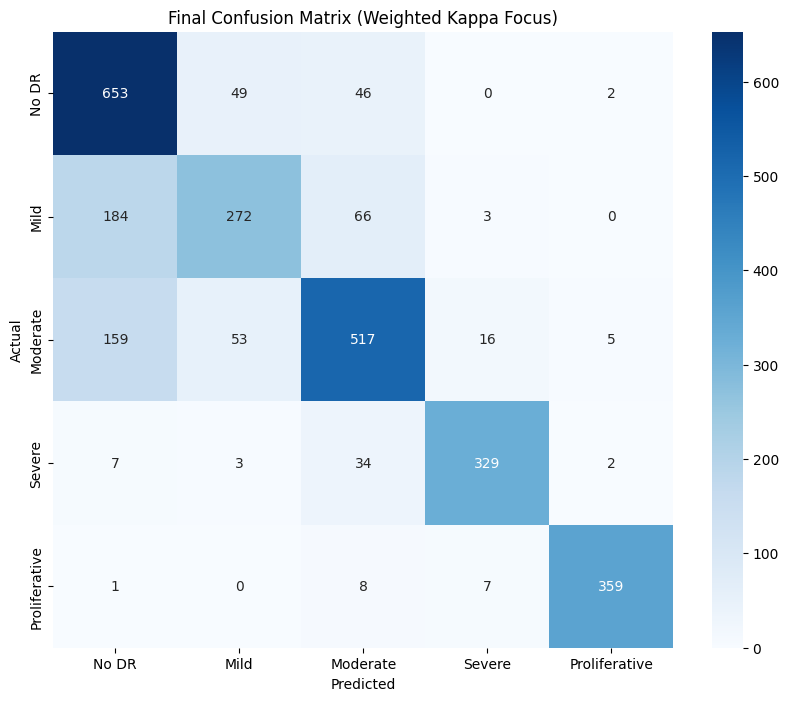

In [6]:
def final_evaluation(model, val_loader, device):
    model.load_state_dict(torch.load("best_efficientnetv2_rw_s.pth"))
    model.eval()
    
    all_preds, all_labs = [], []
    
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc="Final Evaluation"):
            with torch.amp.autocast('cuda'):
                outputs = model(images.to(device))
            all_preds.extend(torch.argmax(outputs, 1).cpu().numpy())
            all_labs.extend(labels.numpy())
    
    # 1. Classification Report (Precision, Recall, F1)
    classes = ["No DR", "Mild", "Moderate", "Severe", "Proliferative"]
    report = classification_report(all_labs, all_preds, target_names=classes)
    print("\nDetailed Classification Report:\n", report)
    
    # 2. Confusion Matrix Heatmap
    cm = confusion_matrix(all_labs, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title('Final Confusion Matrix (Weighted Kappa Focus)')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.savefig("final_confusion_matrix.png")
    plt.show()

final_evaluation(model, val_loader, DEVICE)

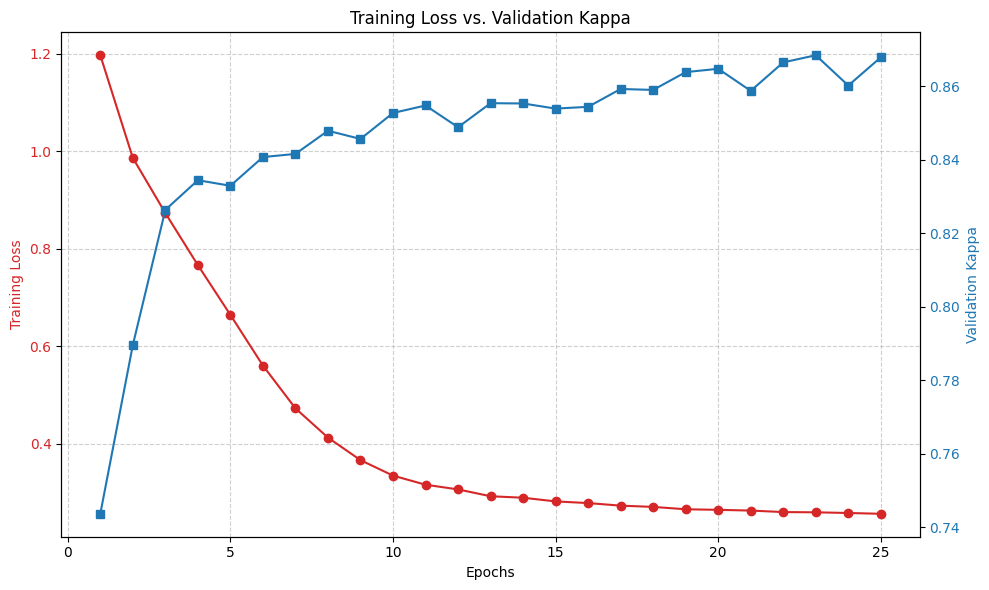

In [7]:
def plot_training_results(history):
    epochs = range(1, len(history) + 1)
    train_loss = [h['train_loss'] for h in history]
    val_kappa = [h['val_kappa'] for h in history]

    fig, ax1 = plt.subplots(figsize=(10, 6))

    # Plot Loss 
    color = 'tab:red'
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Training Loss', color=color)
    ax1.plot(epochs, train_loss, color=color, marker='o', label='Train Loss')
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.grid(True, linestyle='--', alpha=0.6)

    # Plot Kappa on the same chart (Secondary Axis) 
    ax2 = ax1.twinx() 
    color = 'tab:blue'
    ax2.set_ylabel('Validation Kappa', color=color)
    ax2.plot(epochs, val_kappa, color=color, marker='s', label='Val Kappa')
    ax2.tick_params(axis='y', labelcolor=color)

    plt.title('Training Loss vs. Validation Kappa')
    fig.tight_layout()
    plt.savefig('learning_curves.png')
    plt.show()

plot_training_results(history)

# Grad Cam

In [8]:
import cv2
import numpy as np

def generate_gradcam(model, img_tensor, label):
    model.eval()
    
    # 1. Hook into the last conv layer
    # For EfficientNet, the last conv layer is usually 'conv_head'
    features = []
    gradients = []

    def save_feature(module, input, output):
        features.append(output)
    def save_gradient(module, grad_input, grad_output):
        gradients.append(grad_output[0])

    # Register hooks
    handle_feat = model.conv_head.register_forward_hook(save_feature)
    handle_grad = model.conv_head.register_full_backward_hook(save_gradient)

    # 2. Forward pass
    output = model(img_tensor.to(DEVICE))
    score = output[:, label]
    
    # 3. Backward pass
    model.zero_grad()
    score.backward()

    # 4. Generate Heatmap
    grads = gradients[0].cpu().data.numpy()
    feats = features[0].cpu().data.numpy()[0]
    weights = np.mean(grads, axis=(2, 3))[0]
    
    cam = np.zeros(feats.shape[1:], dtype=np.float32)
    for i, w in enumerate(weights):
        cam += w * feats[i]

    # 5. Clean up
    cam = np.maximum(cam, 0)
    cam = cv2.resize(cam, (640, 640))
    cam = (cam - cam.min()) / (cam.max() - cam.min())
    
    handle_feat.remove()
    handle_grad.remove()
    
    return cam

In [9]:
def plot_gradcam(img_path, model, transform):
    # Load and prep image
    img_pil = Image.open(img_path).convert('RGB')
    input_tensor = transform(img_pil).unsqueeze(0)
    
    # Get prediction
    with torch.no_grad():
        pred = torch.argmax(model(input_tensor.to(DEVICE)), 1).item()
    
    # Generate CAM
    cam = generate_gradcam(model, input_tensor, pred)
    
    # Overlay
    img_np = np.array(img_pil.resize((640, 640)))
    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
    overlay = cv2.addWeighted(img_np, 0.6, heatmap, 0.4, 0)
    
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(img_np)
    plt.title(f"Original (Pred: {pred})")
    plt.subplot(1, 2, 2)
    plt.imshow(overlay)
    plt.title("Grad-CAM Focus")
    plt.show()

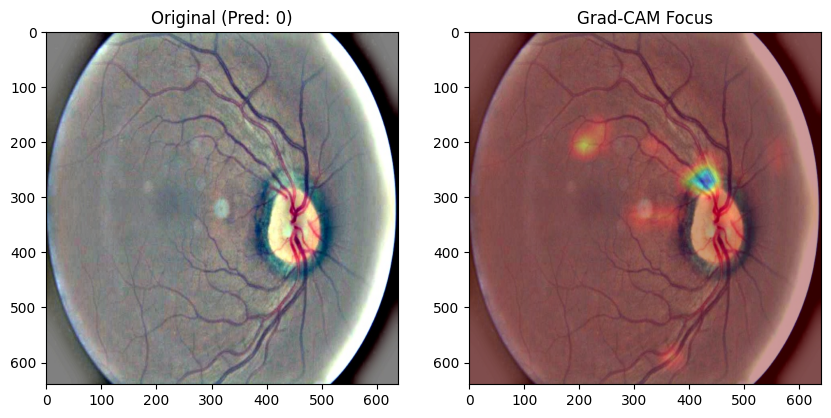

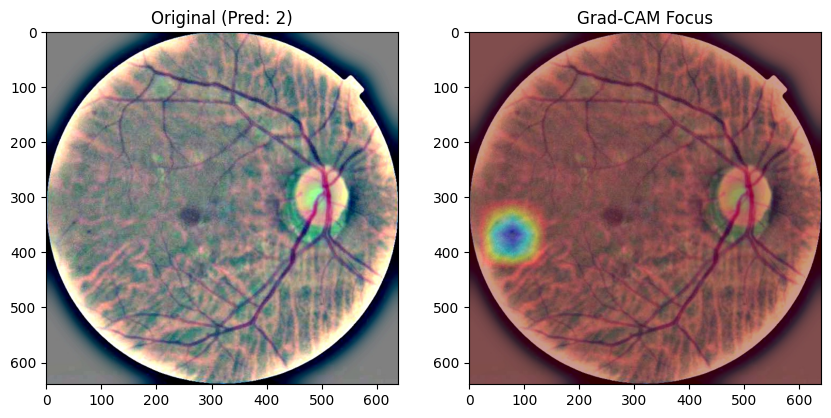

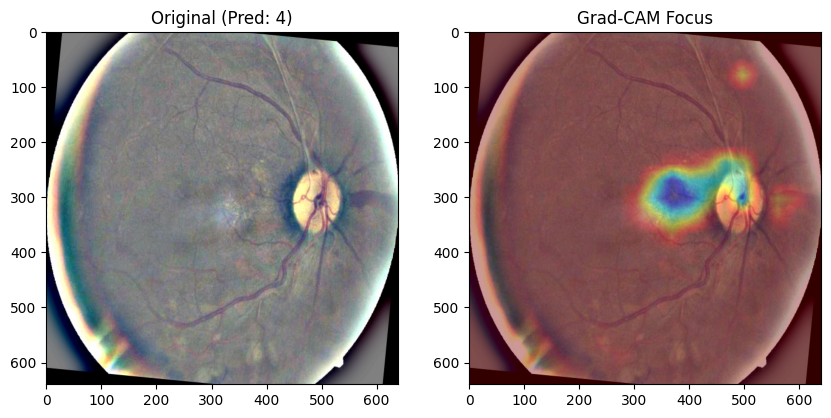

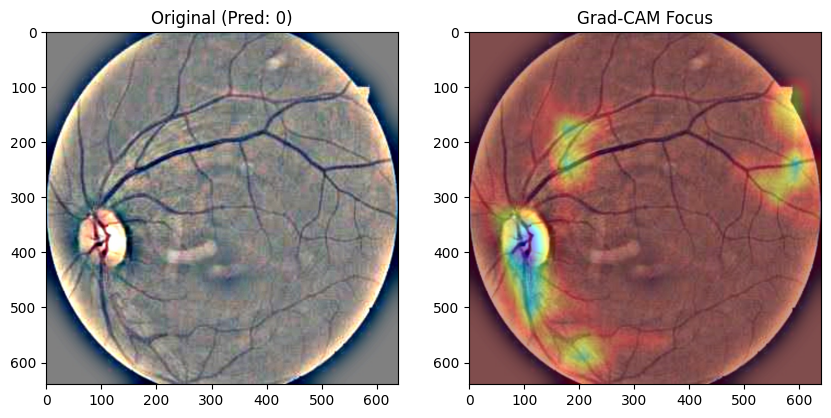

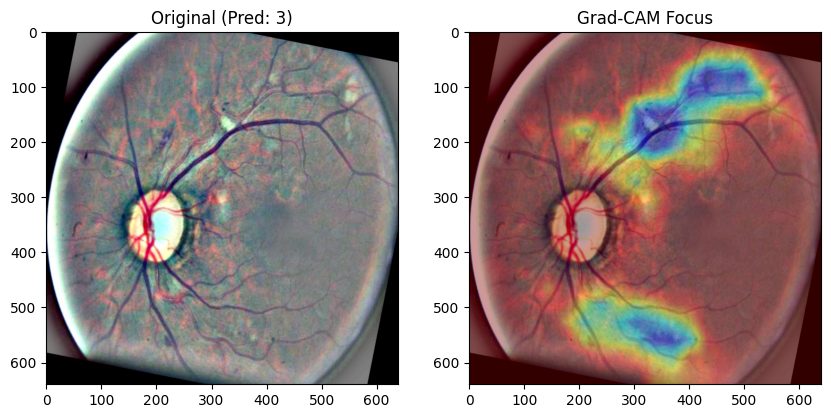

In [10]:
# 1. Load the best weights back into the model
model.load_state_dict(torch.load("best_efficientnetv2_rw_s.pth"))

# 2. Pick a few images from the validation set to test
sample_paths = X_test[:5]  # Just the first 5 images for a quick check

for path in sample_paths:
    plot_gradcam(path, model, val_transform)